In [1]:
# initial imports
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

## Kaggle Diabetes Dataset
### https://www.kaggle.com/datasets/akshaydattatraykhare/diabetes-dataset


<AxesSubplot:>

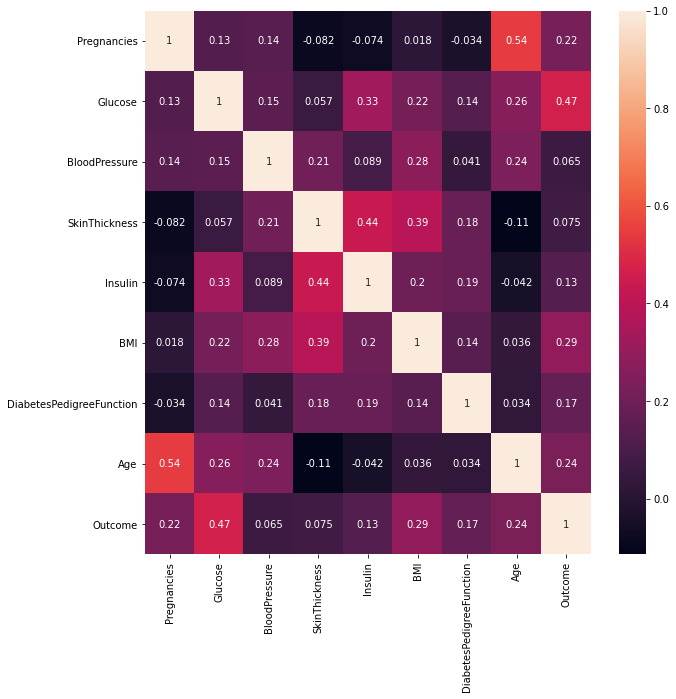

In [5]:
diabetes1_df = pd.read_csv('Datasets/diabetes.csv')

fig, ax = plt.subplots(figsize = (10,10))
diabetes1df_corrs = diabetes1_df.corr()

sns.heatmap(diabetes1df_corrs, ax = ax, annot = True)

In [6]:
x = diabetes1_df.drop('Outcome', axis=1)
y = diabetes1_df['Outcome']

results = sm.OLS(y, x).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                Outcome   R-squared (uncentered):                   0.487
Model:                            OLS   Adj. R-squared (uncentered):              0.481
Method:                 Least Squares   F-statistic:                              90.10
Date:                Wed, 05 Apr 2023   Prob (F-statistic):                   9.04e-105
Time:                        01:16:16   Log-Likelihood:                         -429.34
No. Observations:                 768   AIC:                                      874.7
Df Residuals:                     760   BIC:                                      911.8
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

## CDC Diabetes Survaliance (Total)
### https://gis.cdc.gov/grasp/diabetes/diabetesatlas-surveillance.html

In [3]:
diabetes2_df = pd.read_csv('DiabetesAtlas_NationalData.csv',skiprows=2,usecols=[0, 1,2,3] )


diabetes2_df.head(6)
#This dataset needs to be added to Datasets directory, downloading this wasn't working for me

,Year,Total - Percentage,Total - Lower Limit,Total - Upper Limit
0,2000,6.0,5.7,6.3
1,2001,6.4,6.1,6.8
2,2002,6.5,6.2,6.8
3,2003,6.6,6.3,6.9
4,2004,7.0,6.7,7.3
5,2005,7.3,7.0,7.6


In [14]:
#Removing useless spreadsheet cells
fixed= diabetes2_df.drop([0,22])
#cleaning up data so it can easily be graphed
diabetes2_df=fixed.dropna(axis='columns')

#assigning certain columns as variables using iloc to index them
year = np.array(diabetes2_df.iloc[0:,0])
#turning years to integers as it previously was reading as a string
years = np.int_(year)
total = np.array(diabetes2_df.iloc[0:,1])
low = np.array(diabetes2_df.iloc[0:,2])
high = np.array(diabetes2_df.iloc[0:,3])

#displaying the whole dataset, obtained from the cdc source 
diabetes2_df

,Year,Total - Percentage,Total - Lower Limit,Total - Upper Limit
1,2001,6.4,6.1,6.8
2,2002,6.5,6.2,6.8
3,2003,6.6,6.3,6.9
4,2004,7.0,6.7,7.3
5,2005,7.3,7.0,7.6
6,2006,7.6,7.2,8.0
7,2007,7.5,7.1,7.9
8,2008,7.9,7.5,8.4
9,2009,8.6,8.2,9.0
10,2010,8.7,8.3,9.1


In [15]:
#Curve fit function
def prediction(x,m,b):
    #the return statement which is the actual function part
    return m*x+b

In [16]:
#Curve fitting for Total-Percentage Column
#best_fit_total is my new variable I will fill with the values from the curve_fit function
#curve_fit is from scipy and takes in a function, x, and y values.
best_fit_total, just_ignore_this= curve_fit(prediction,years,total)

# Displays the best fit parameters which are m, and b respectively
print(best_fit_total)

[ 1.07142857e-01 -2.07473810e+02]


In [17]:
#the value of the m portion of the linear function for total
m_t=best_fit_total[0]
#the value of the +b portion of the linear function for total
b_t=best_fit_total[1]

#Creates an array showing all the values for the y axis on the total
ytotal= prediction(years,m_t,b_t)

print(ytotal)

[6.91904761 7.02619047 7.13333333 7.24047619 7.34761904 7.4547619
 7.56190476 7.66904761 7.77619047 7.88333333 7.99047619 8.09761904
 8.2047619  8.31190476 8.41904761 8.52619047 8.63333333 8.74047619
 8.84761904 8.9547619  9.06190476]


In [23]:
#Curve fitting for Total-Low Column
best_fit_low, just_ignore_this= curve_fit(prediction,years,low)

print(best_fit_low)

[ 1.05194805e-01 -2.03903896e+02]


In [19]:
#
m_l=best_fit_low[0]
b_l=best_fit_low[1]

ylow= prediction(years,m_l,b_l)
print(ylow)

[6.59090909 6.69610389 6.8012987  6.9064935  7.01168831 7.11688311
 7.22207792 7.32727272 7.43246753 7.53766233 7.64285714 7.74805194
 7.85324675 7.95844155 8.06363636 8.16883116 8.27402597 8.37922077
 8.48441558 8.58961039 8.69480519]


In [20]:
#Curve fitting for Total-High Column
best_fit_high, just_ignore_this = curve_fit(prediction,years,high)

print(best_fit_high)

[ 1.09610390e-01 -2.12064589e+02]


In [21]:
#
m_h=best_fit_high[0]
b_h=best_fit_high[1]

yhigh= prediction(years,m_h,b_h)

print(yhigh)

[7.26580086 7.37541125 7.48502164 7.59463203 7.70424242 7.81385281
 7.9234632  8.03307359 8.14268398 8.25229437 8.36190476 8.47151515
 8.58112554 8.69073593 8.80034632 8.90995671 9.0195671  9.12917748
 9.23878787 9.34839826 9.45800865]


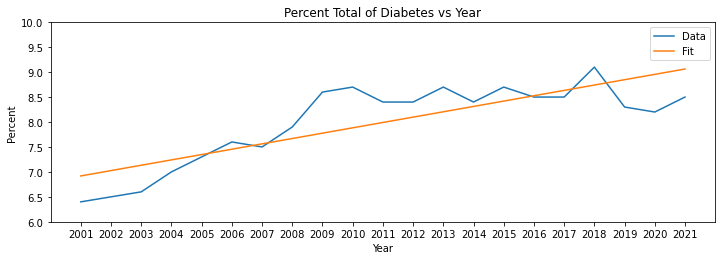

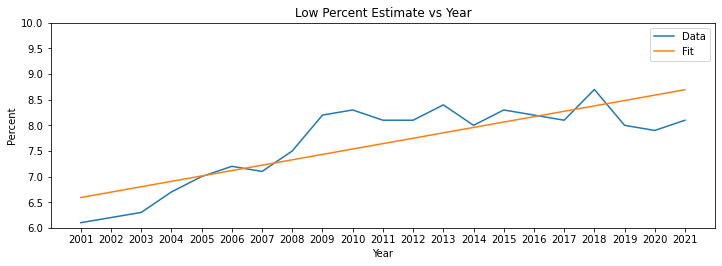

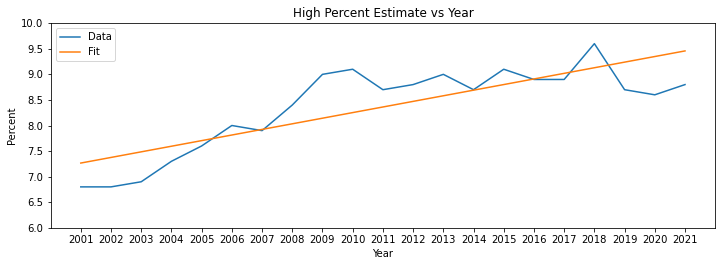

In [22]:
#Graphing the three curve fits with actual data

#Total Graph and Fit
#Setting the size of the graphs
plt.figure(figsize=(10,10))
 #Creating multiple plots
plt.subplot(3,1,1)
#Plotting data
plt.plot(years,total,label='Data')
# Plotting curve fit
plt.plot(years,ytotal,label='Fit') 
#Naming the graph to help differentiate
plt.title("Percent Total of Diabetes vs Year") 
#Labeling the x axis
plt.xlabel("Year")
#Labeling the y axis
plt.ylabel("Percent")
#Making a tick mark for each year, rather than the autogenerate x axis which has odd values like "2002.5"
plt.xticks(years)
#Displays labels given to lines
plt.legend()
#Trying to make each graph look similar enough to compare easily
plt.ylim(6,10)
#Makes the graphs much cleaner, and far less cramped
plt.tight_layout()

#High Graph and Fit
plt.figure(figsize=(10,10))
plt.subplot(3,1,2)
plt.plot(years,low,label="Data")
plt.plot(years,ylow,label='Fit')
plt.title("Low Percent Estimate vs Year")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.xticks(years)
plt.ylim(6,10)
plt.legend()

plt.tight_layout()

#Low Graph and Fit
plt.figure(figsize=(10,10))
plt.subplot(3,1,3)
plt.plot(years,high,label="Data")
plt.plot(years,yhigh,label='Fit')
plt.title("High Percent Estimate vs Year")
plt.xlabel("Year")
plt.ylabel("Percent")
plt.xticks(years)
plt.legend()
plt.ylim(6,10)
plt.tight_layout()

## Kaggle Heart Disease Indicator ( with smoking9)
### https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset

In [21]:
hd_indicators_df = pd.read_csv('Datasets/heart_disease_health_indicators_BRFSS2015.csv')

hd_indicators_df.describe()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.094186,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.296921,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.292087,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.698160,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


<AxesSubplot:>

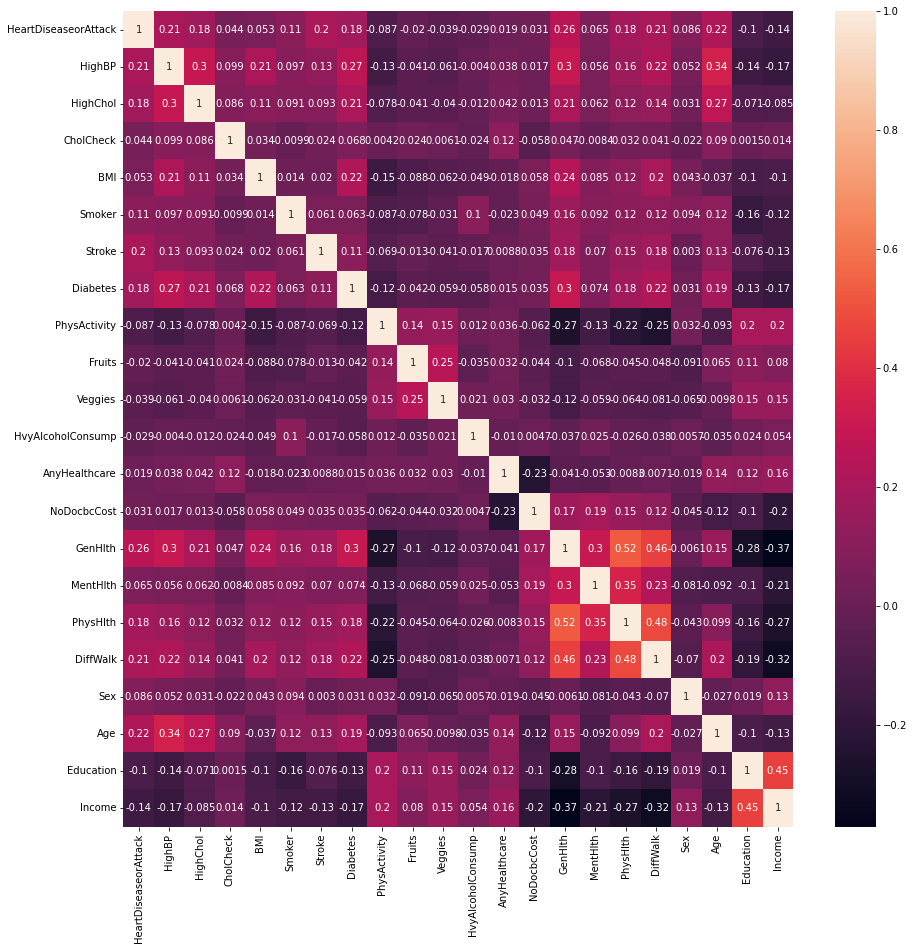

In [28]:

fig, ax = plt.subplots(figsize = (15,15))
diabetes_df_corrs = hd_indicators_df.corr()

sns.heatmap(diabetes_df_corrs, ax = ax, annot = True)


In [29]:
x = hd_indicators_df.drop('Diabetes', axis=1)
y = hd_indicators_df['Diabetes']

results = sm.OLS(y, x).fit()
print(results.summary())

#TODO: remove insignificant variables and make plots

                                 OLS Regression Results                                
Dep. Variable:               Diabetes   R-squared (uncentered):                   0.294
Model:                            OLS   Adj. R-squared (uncentered):              0.294
Method:                 Least Squares   F-statistic:                              5024.
Date:                Tue, 04 Apr 2023   Prob (F-statistic):                        0.00
Time:                        20:33:32   Log-Likelihood:                     -2.4578e+05
No. Observations:              253680   AIC:                                  4.916e+05
Df Residuals:                  253659   BIC:                                  4.918e+05
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------